In [1]:
!pip install qiskit-algorithms

In [7]:
!pip install qiskit-aer

  Using cached qiskit_aer-0.17.1-cp312-cp312-win_amd64.whl.metadata (8.5 kB)
Using cached qiskit_aer-0.17.1-cp312-cp312-win_amd64.whl (9.5 MB)


In [8]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA
import numpy as np

# Part 1 : Ideal VQE Simulation

**Task** : Use qiskit.quantum_info.SparsePauliOp to create the 2-qubit Hamiltonian for  H2  at interatomic distance of 0.735 Å:

H=(−1.052⋅II)+(0.398⋅IZ)−(0.398⋅ZI)−(0.011⋅ZZ)+(0.181⋅XX)

In [10]:
Hamiltonian = SparsePauliOp.from_list([("II", -1.052), ("IZ", 0.398), ("ZI", -0.398), ("ZZ", -0.011), ("XX", 0.181)])
# By this, we created the Hamiltonian, that is, the energy operator, that we will use later to find out the average energy of a system using its wavefunction
print(Hamiltonian)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.052+0.j,  0.398+0.j, -0.398+0.j, -0.011+0.j,  0.181+0.j])


**Task** : Use TwoLocal as the ansatz

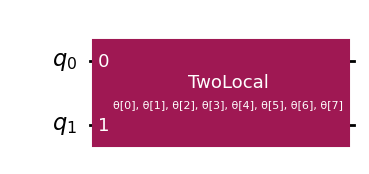

In [12]:
ansatz = TwoLocal(2, 'ry', 'cz') # Creating a 2 qubit circuit and apply Ry on each qubit (the angle in Ry can be varied) and therefore, by writing...
                                 # ... this code, we leave it on the algorithm to iteratively change the angle until we converge and get the...
                                 # ... minimum energy value, which will be our closest approximation to the ground state energy of the H2 molecule
                                 # CZ creates entanglement between both the qubits (electrons of H2 molecule) to take into account the...
                                 # ... inter-electronic interaction while determining the ground state energy
ansatz.draw('mpl')
# So the 2 qubit system that we have created here is the 2 electron system of H2 molecule and the parameter theta of Ry makes it as a function of...
#... theta instead of writing a strict wavefuction. Varying this theta varies the wavefunction until we get the theta that gives the wavefunction...
#... which has the minimum energy

**Task** : Choose the SPSA optimizer

In [14]:
opt = SPSA(maxiter=50) # This tells the algorithm how to tweak the value of theta until we get to minimum energy

**Task** : Use qiskit.primitives.Estimator for noise-free simulation

In [16]:
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE

estimator = Estimator() # This is the function that calculates the average energy of our wavefunction
vqe = VQE(estimator, ansatz, opt)

C:\Users\Abbas\AppData\Local\Temp\ipykernel_16712\3290328223.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator() # This is the function that calculates the average energy of our wavefunction


**Task** : Run the algorithm and print the final computed ground state energy.

In [18]:
result = vqe.compute_minimum_eigenvalue(Hamiltonian)
print(result.eigenvalue)

-1.8572043540684784


------

# Part 2

**Task** : Use qiskit_aer.noise to create a NoiseModel. Introduce bit-flip (Pauli  X ) error with probability 0.05 after each CNOT.

In [20]:
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)]) # introducing error using X and I gates for 1 qubit
bit_flip_2_qubits = bit_flip.tensor(bit_flip) # creating a tensor product of the above error gate, so that we can apply this on our 2 qubit system
# What this tensor function does is, it applies the error on both qubits independently. So probabilities get multiplied.
# For eg, Probability of both qubits getting flipped is 0.05*0.05, and probability both not flipping is 0.95*0.95 and so on for individual flip case

**Task** : Use qiskit_aer.primitives.Estimator

In [22]:
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import AerSimulator

**Task** : Apply your noise model

In [24]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(bit_flip_2_qubits, ['cx'])

**Task** : Re-run VQE and report energy. Compare with ideal case.

In [26]:
# STEP 4: Create Noisy Simulator Backend
sim_noise = AerSimulator(noise_model=noise_model)

# STEP 5: Set up Noisy Estimator
noisy_estimator = AerEstimator(backend_options={"noise_model": noise_model}, run_options={"shots": 2048})

# Run VQE
vqe_noisy = VQE(noisy_estimator, ansatz, opt)

result_noisy = vqe_noisy.compute_minimum_eigenvalue(Hamiltonian)
print(result_noisy.eigenvalue)

-1.7789150390625001


**Comparision** : To compare both the results, lets look at the relative error and the percentage error that we got [PH 117 lab me jo sikha kahi toh kaam aa raha hai :') ] . Relative error is 

In [27]:
print (abs((result_noisy.eigenvalue-result.eigenvalue)/result.eigenvalue))
# Here I haven't written result.eigenvalue.real because since we are using HAMILTONIAN to find the ground state ENERGY of the H2 molecule, ...
#... all the eigen values are real

0.04215438911419415


And the percentage error is

In [28]:
print ((abs((result_noisy.eigenvalue-result.eigenvalue)/result.eigenvalue))*100)

4.215438911419414


Therefore, we got a 4.2 % error while using the noisy simulator

-----

# Part 3

**Task** : Write a function that takes a QuantumCircuit and a 1-qubit QuantumRegister input. Add gates to encode logical qubit into 3 physical qubits using bit-flip code.

In [33]:
def QEC_encoder (qc, qubit) :
    qc.cx(qubit, qubit+1)
    qc.cx(qubit, qubit+2)
    return qc

**Explanation** : What we are doing here is, we are checking if the particular qubit is 0 or 1, and applying X gate accordingly. So, if we create a 3 qubit quantum circuit, all qubits initially are in state 0 by default, therefore we have $\ket {000}$. Now after apply H on qubit 0 we get
$$\ket + = 1/\sqrt 2 (\ket {000} + \ket {100})$$
So now, when we execute our code on this ket $\ket +$, after the first qc.cx, we end up with 
$$1/\sqrt 2 (\ket {000} + \ket {110})$$
And after the second qc.cx, we finally get
$$1/\sqrt 2 (\ket {000} + \ket {111})$$
As required

**Task** : Add gates for a full syndrome measurement cycle using 2 ancilla qubits and a classical register.

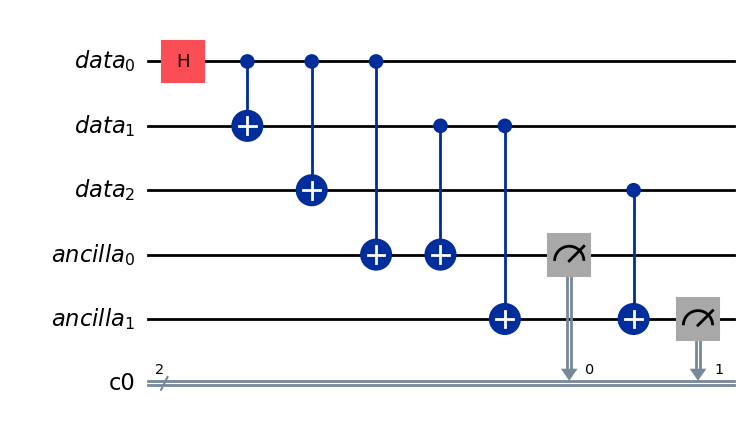

In [35]:
data = QuantumRegister(3, name = "data") # For storing each logical qubit into 3 physical qubits
ancilla = QuantumRegister(2, name = "ancilla") # To store outcomes of comparing qubits pairwise
cl = ClassicalRegister(2) # To store the measurement of the ancilla qubits

qc = QuantumCircuit (data, ancilla, cl)
qc.h(0)

QEC_encoder(qc,0)

qc.cx(data[0], ancilla[0])
qc.cx(data[1], ancilla[0])

qc.cx(data[1], ancilla[1])
qc.cx(data[2], ancilla[1])

qc.measure (ancilla, cl)

qc.draw('mpl')

**Task** : Add gates to apply corrective  X  operations based on syndrome outcomes.

Syndrome: 00


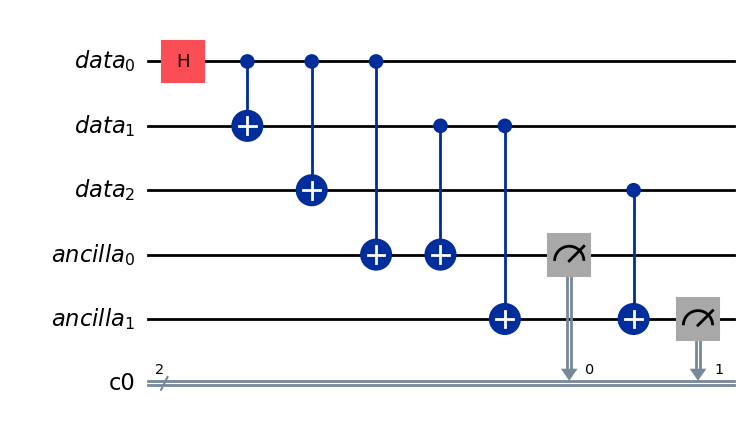

In [37]:
simulator = AerSimulator()
tqc = transpile(qc, simulator)
result = simulator.run(tqc, shots=1).result()
syndrome = list(result.get_counts().keys())[0]

print("Syndrome:", syndrome)

if syndrome == '10':
    qc.x(data[0])
elif syndrome == '11':
    qc.x(data[1])
elif syndrome == '01':
    qc.x(data[2])

qc.draw('mpl')

-------

# Part 4

**Task** : Use logical and ancilla qubits

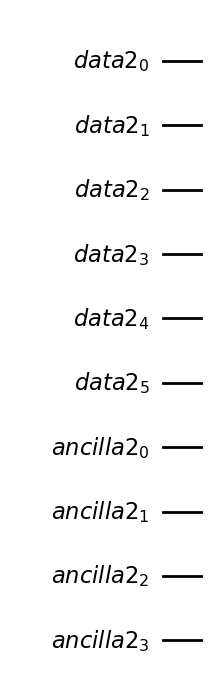

In [109]:
data2 = QuantumRegister(6, name="data2")        # 2 logical qubits means 6 physical qubits
ancilla2 = QuantumRegister(4, name="ancilla2")  # 2 per logical qubit for error correction

qc2 = QuantumCircuit(data2, ancilla2)

qc2.draw('mpl')

**Task** : Apply encoding circuit

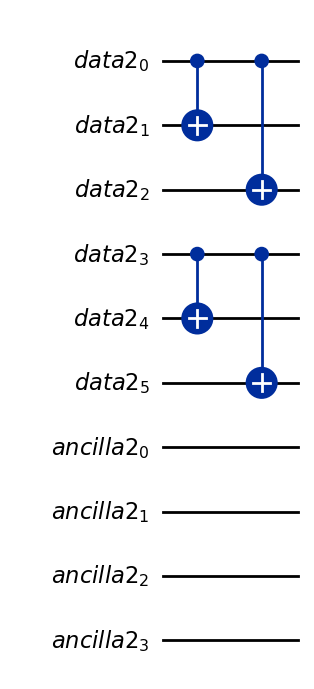

In [111]:
# Logical Qubit 1
qc2.cx(data2[0], data2[1])
qc2.cx(data2[0], data2[2])

# Logical Qubit 2
qc2.cx(data2[3], data2[4])
qc2.cx(data2[3], data2[5])

qc2.draw('mpl')

**Task** : Insert translated TwoLocal ansatz gates (logical  →  physical)

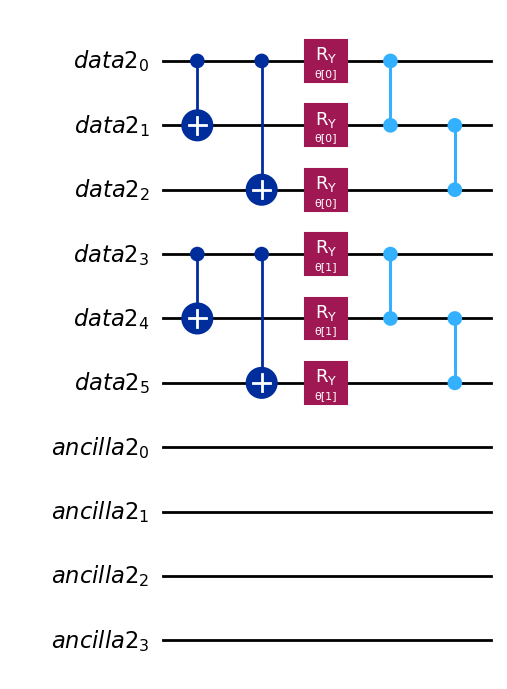

In [113]:
from numpy import pi
from qiskit.circuit import ParameterVector

# This is a manually translated version of Ry + CZ entanglement for encoded qubit
# We have to do this instead of directly using ansatz = TwoLocal (6, 'ry', 'cz') because this one-line method applies different theta on...
# ... all the 6 qubits while applying Ry but the 6 physical qubits represent a total of 2 logical qubits, so we want the angle to be same on...
#... the first three qubits and same on next set of 3 qubits but different from first angle so that both logical qubits have different angles

params = ParameterVector('θ', 2)

# Ansatz with parameters
# Logical qubit 0
qc2.ry(params[0], data2[0])
qc2.ry(params[0], data2[1])
qc2.ry(params[0], data2[2])

# Logical qubit 1
qc2.ry(params[1], data2[3])
qc2.ry(params[1], data2[4])
qc2.ry(params[1], data2[5])

# Entanglement 
qc2.cz(data2[0], data2[1])
qc2.cz(data2[1], data2[2])
qc2.cz(data2[3], data2[4])
qc2.cz(data2[4], data2[5])

qc2.draw('mpl')

**Task** : Apply syndrome measurement and correction

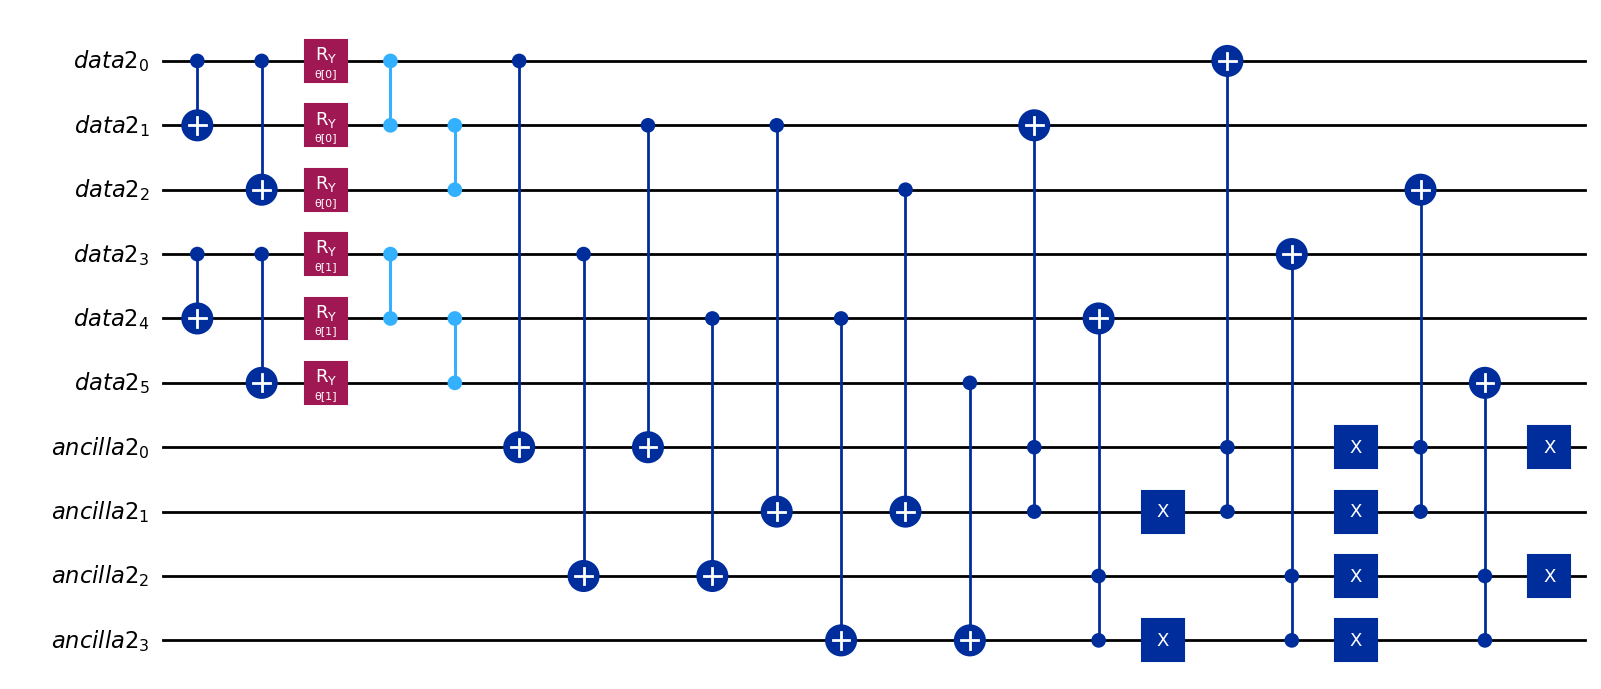

In [115]:
# for qubit 1
qc2.cx(data2[0], ancilla2[0])
qc2.cx(data2[1], ancilla2[0])
qc2.cx(data2[1], ancilla2[1])
qc2.cx(data2[2], ancilla2[1])

# I have used toffolli gates here for error correction since we cannot use qc2.measure () like earlier because that is not compatible with VQE

qc2.ccx(ancilla2[1], ancilla2[0], data2[1])      # syndrome 11
qc2.x(ancilla2[1])
qc2.ccx(ancilla2[0], ancilla2[1], data2[0])      # syndrome 10
qc2.x(ancilla2[1])
qc2.x(ancilla2[0])
qc2.ccx(ancilla2[1], ancilla2[0], data2[2])      # syndrome 01
qc2.x(ancilla2[0])

# for qubit 2
qc2.cx(data2[3], ancilla2[2])
qc2.cx(data2[4], ancilla2[2])
qc2.cx(data2[4], ancilla2[3])
qc2.cx(data2[5], ancilla2[3])

qc2.ccx(ancilla2[3], ancilla2[2], data2[4])      # syndrome 11
qc2.x(ancilla2[3])
qc2.ccx(ancilla2[2], ancilla2[3], data2[3])      # syndrome 10
qc2.x(ancilla2[3])
qc2.x(ancilla2[2])
qc2.ccx(ancilla2[3], ancilla2[2], data2[5])      # syndrome 01
qc2.x(ancilla2[2])

qc2.draw('mpl')

**Task** : Decode using inverse of the encoding circuit

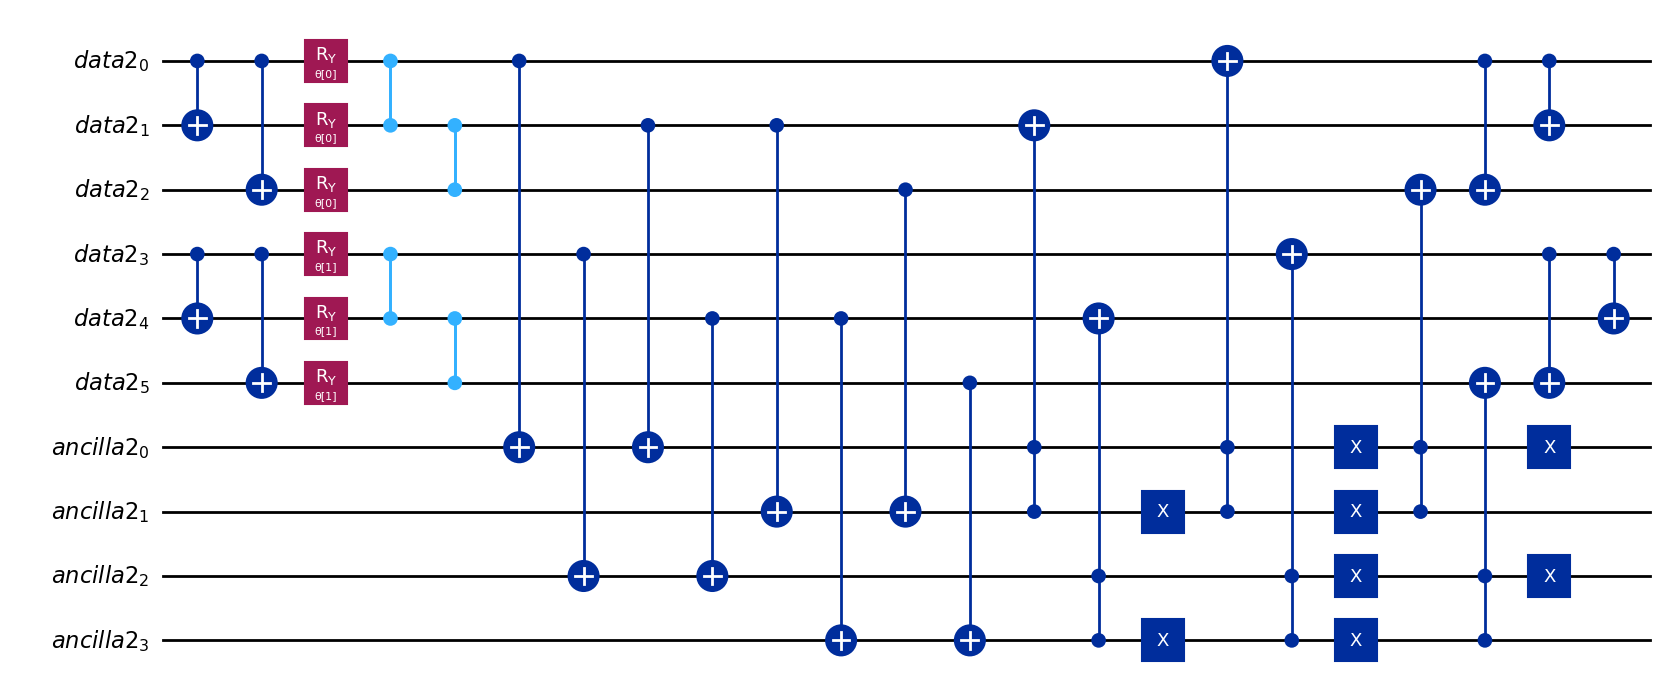

In [117]:
qc2.cx(data2[0], data2[2])
qc2.cx(data2[0], data2[1])

qc2.cx(data2[3], data2[5])
qc2.cx(data2[3], data2[4])

qc2.draw('mpl')

**Task** : Execute with noisy estimator using your protected ansatz

In [119]:
# Define Hamiltonian for 6 qubits because earlier we used it for 2 qubits and now we have converted each logical qubit into 3 physical qubits
hamiltonian = SparsePauliOp.from_list([("IIIIII", -1.052), ("IIIZZZ", 0.398), ("ZZZIII", -0.398), ("ZZZZZZ", -0.011), ("XXXXXX", 0.181)])

id_ancilla = SparsePauliOp("I" * 4)  # Extend to 10 qubits because the circuit qc2 has 10 qubits

extended_hamiltonian = hamiltonian.tensor(id_ancilla)


# Add Noise Model
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
bit_flip_2_qubits = bit_flip.tensor(bit_flip) 

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(bit_flip_2_qubits, ['cx'])

# Noisy Backend & Estimator
sim_noise = AerSimulator(noise_model=noise_model)
noisy_estimator = AerEstimator(backend_options={"noise_model": noise_model}, run_options={"shots": 2048})

# Optimizer
opt = SPSA(maxiter=50) 

# Run VQE
vqe_noisy2 = VQE(estimator=noisy_estimator, ansatz=qc2, optimizer=opt, initial_point=[pi/4, pi/4]) # pi/4 is the value of those theta1 and theta2 parameters
result_noisy2 = vqe_noisy2.compute_minimum_eigenvalue(operator=extended_hamiltonian)

**Task** : Print final energy from protected run.

In [122]:
print("Protected eigenvalue (noisy):", result_noisy2.eigenvalue)

Protected eigenvalue (noisy): -1.0631591796875002
